# Imports


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from math import ceil

# Access functions

In [25]:
def p2f(x):
    return float(x.strip('%').replace(',', '.'))/100

In [89]:
def retrieve_misses(path, outname):
    """
    This function retrieves theb timing of a certain sequential or pthreads computation.

    Input:
     - path: inner path to the folder containing a result (consider to address a path/job.out)

    Output:
     - A float representing time or an error
    """
    f = open(path + "/" + outname, "r")
    return int(f.readlines()[6].split()[0].replace('.', ''))

In [84]:
# Testing

retrieve_misses("mpi_bcast/0", "1.txt")

121024

In [4]:
def retrieve_settings(path):
    """
    This function retrieves all the settings for a certain measurement.

    Input:
     - path: inner path to the folder containing a result (consider to address a path/job.out)

    Output: 
     - A numpy array of settings in format np.float64
    """
    options = path.split("/")
    settings = np.array([], dtype=np.float64)
    for set in options:
        if not str.isalpha(set.split("_")[-1]):
            settings = np.append(settings, np.float64(set.split("_")[-1]))
            
    return settings

# Dataset creation

In [112]:
def raw_dataset(methods, n_settings):
    """
    This function recursively explores the results folder and gathers data about the measurements.

    Input:
     - path: the path of the dataset
     - dataset: whatever numpy array of np.float64 with the same dimension as the measurement variables
     - retrieval: the time retrieving function

     Output: 
      - The dataset as a numpy array of np.float64. The shape of the array is (measurements, variables),
        where the last variable is the timing of the measurement
    """
    dataset = np.zeros((1, n_settings*2), dtype=np.float32)
    for method in methods:
        row = np.array([], dtype=np.float32)
        for setting in range(n_settings):
            datapoint = np.array([], dtype=np.float32)
            for test_n in range(1, 10):
                value = retrieve_misses(f"{method}/{setting}", f"{test_n}.txt")
                #print(f"Method: {method}\nSetting: {setting}\nTest n.: {test_n}\nValue: {value}")
                datapoint = np.append(datapoint, value)


            std = np.format_float_scientific(np.std(datapoint), precision=2)
            mean = np.format_float_scientific(np.mean(datapoint), precision=2)
            row = np.append(row, [mean, std])

        dataset = np.append(dataset, row.reshape(1, -1), axis=0)
                
    return dataset[1:]

In [113]:
# Testing
methods = ["sequential", "pthreads", "mpi", "mpi_exp", "mpi_bcast", "mpi_pthreads"]
n_settings = 4
raw_dataset(methods, n_settings)

array([['5.04e+04', '6.15e+02', '7.58e+04', '4.21e+03', '1.07e+06',
        '2.32e+05', '8.77e+05', '7.26e+04'],
       ['7.19e+04', '1.08e+03', '1.15e+05', '4.21e+03', '9.39e+05',
        '1.51e+05', '9.25e+05', '8.57e+04'],
       ['1.18e+05', '1.67e+03', '1.2e+05', '2.92e+03', '1.18e+05',
        '2.45e+03', '1.21e+05', '3.95e+03'],
       ['1.19e+05', '1.99e+03', '1.2e+05', '1.81e+03', '1.19e+05',
        '2.41e+03', '1.19e+05', '1.38e+03'],
       ['1.18e+05', '2.12e+03', '1.20e+05', '3.84e+03', '1.20e+05',
        '4.82e+03', '1.2e+05', '3.9e+03'],
       ['1.18e+05', '2.08e+03', '1.2e+05', '3.17e+03', '1.21e+05',
        '7.35e+03', '1.19e+05', '4.06e+03']], dtype='<U32')

## Clean dataset

In [115]:
methods = ["sequential", "pthreads", "mpi", "mpi_exp", "mpi_bcast", "mpi_pthreads"]
n_settings = 5
df = pd.DataFrame(raw_dataset(methods, n_settings), index=methods)

# Renaming the row and columns
for i in range(df.shape[1]//2):
    df.rename(columns={2*i: f"Set. {i} mean misses", 2*i+1: f"Set. {i} std"}, inplace=True)

df

,Set. 0 mean misses,Set. 0 std,Set. 1 mean misses,Set. 1 std,Set. 2 mean misses,Set. 2 std,Set. 3 mean misses,Set. 3 std,Set. 4 mean misses,Set. 4 std
sequential,5.08e+04,8.40e+02,1.07e+06,2.16e+05,8.58e+05,6.65e+04,4.13e+06,4.82e+05,8.33e+07,5.34e+06
pthreads,7.15e+04,1.94e+03,9.75e+05,1.13e+05,9.11e+05,2.04e+04,3.94e+06,4.24e+05,8.44e+07,7.85e+06
mpi,1.18e+05,4.17e+03,1.23e+05,8.65e+03,1.18e+05,1.13e+03,1.19e+05,1.41e+03,1.33e+05,4.37e+04
mpi_exp,1.19e+05,2.70e+03,1.2e+05,3.33e+03,1.18e+05,1.73e+03,1.18e+05,3.35e+03,1.18e+05,3.6e+03
mpi_bcast,1.18e+05,1.54e+03,1.2e+05,4.60e+03,1.2e+05,4.51e+03,1.2e+05,4.55e+03,1.17e+05,1.74e+03
mpi_pthreads,1.18e+05,1.43e+03,1.18e+05,2.51e+03,1.18e+05,1.64e+03,1.21e+05,2.7e+03,1.19e+05,4.66e+03


# Comparing datasets


In [13]:
def comparison_mod(seq_data, par_data, idx, variable):
    """
    This function returns an array that compares two datasets on a given variable x.
    It creates an array for each configuration of all the other variables that are not x, 
    effectively comparing the 2 methods as a result of varying a single variable.

    Input:
     - seq_data: an output of create_dataset
     - par_data: an output of create_dataset
     - idx: the dictionary of variables and indices associated to the second dataset
     - variable: the variable we are comparing on

    Output:
     - An array with shape (parallel_configurations, 3, range(variable), i_data.shape[1]) where:
        - parallel_configurations is the possible number of configurations for the parallel dataset on a certain variable, diregarding the number of threads/cores
        - 3 stands for 3 numpy arrays:
            1. A 1-d array with the configuration settings,
            2. Two arrays (sequential and then parallel) with the afore-specified shapes:
                - range(variable) is the number of total settings for that specific variable
                - i_data.shape[1] is the number of columns of the i-th dataset (seq or par_data)
        
        Mind that the last 2 dimensions are a numpy array.
    """
    new_dataset = []

    for const in domain(par_data[:, 1:], idx[variable]):
        values_par = np.copy(par_data)
        values_seq = np.copy(seq_data)
        for i in range(seq_data.shape[1] - 3):
            if i >= idx[variable]:
                values_par = values_par[(values_par[:, i+2] == const[i])]
                values_seq = values_seq[(values_seq[:, i+1] == const[i])]
            else:
                values_par = values_par[(values_par[:, i+1] == const[i])]
                values_seq = values_seq[(values_seq[:, i] == const[i])]

        if values_seq.shape[0] < 2 and values_par.shape[0] < 2:
            print(f"For configuration {const[1:]}, there was not enough data.")
            print(f"Sequential data: {values_seq.shape[0]}")
            print(f"Parallel data: {values_par.shape[0]}")
        else:
            new_dataset.append((const, values_seq, values_par))
            
    return new_dataset

In [101]:
def comparison_seq_pthreads(seq_data, par_data, idx, variable):
    """
    This function returns an array that compares two datasets on a given variable x.
    It creates an array for each configuration of all the other variables that are not x, 
    effectively comparing the 2 methods as a result of varying a single variable.

    Input:
     - seq_data: an output of create_dataset
     - par_data: an output of create_dataset
     - idx: the dictionary of variables and indices associated to the second dataset
     - variable: the variable we are comparing on

    Output:
     - An array with shape (parallel_configurations, 3, range(variable), i_data.shape[1]) where:
        - parallel_configurations is the possible number of configurations for the parallel dataset on a certain variable, diregarding the number of threads/cores
        - 3 stands for 3 numpy arrays:
            1. A 1-d array with the configuration settings,
            2. Two arrays (sequential and then parallel) with the afore-specified shapes:
                - range(variable) is the number of total settings for that specific variable
                - i_data.shape[1] is the number of columns of the i-th dataset (seq or par_data)
        
        Mind that the last 2 dimensions are a numpy array.
    """
    new_dataset = []

    for const in domain(par_data[:, 2:], idx[variable]):
        values_par = np.copy(par_data)
        values_seq = np.copy(seq_data)
        for i in range(seq_data.shape[1] - 3):
            if i >= idx[variable]:
                values_par = values_par[(values_par[:, i+3] == const[i])]
                values_seq = values_seq[(values_seq[:, i+1] == const[i])]
            else:
                values_par = values_par[(values_par[:, i+2] == const[i])]
                values_seq = values_seq[(values_seq[:, i] == const[i])]

        if values_seq.shape[0] < 2 and values_par.shape[0] < 2:
            print(f"For configuration {const[1:]}, there was not enough data.")
            print(f"Sequential data: {values_seq.shape[0]}")
            print(f"Parallel data: {values_par.shape[0]}")
        else:
            new_dataset.append((const, values_seq, values_par))
            
    return new_dataset

In [14]:
def sequential_vs_pthreads(variable):
    """
    A wrapper of the comparison function for sequential and pthreads data.
    """
    return comparison_mod(sequential, pthreads, idx, variable)

In [15]:
# Testing

sequential_vs_pthreads("patterns")

[(array([1024.,   16.]),
  array([[1.02400000e+03, 1.02400000e+03, 1.60000000e+01, 3.87873820e-05,
          6.40030000e-03],
         [1.02400000e+03, 3.27680000e+04, 1.60000000e+01, 6.21536004e-04,
          2.01448600e-01],
         [1.02400000e+03, 1.04857600e+06, 1.60000000e+01, 4.38169893e-02,
          6.51554630e+00]]),
  array([[2.00000000e+00, 1.02400000e+03, 1.02400000e+03, 1.60000000e+01,
          9.05553091e-05, 3.60660000e-03],
         [2.00000000e+00, 1.02400000e+03, 3.27680000e+04, 1.60000000e+01,
          2.80685978e-03, 1.02578900e-01],
         [2.00000000e+00, 1.02400000e+03, 1.04857600e+06, 1.60000000e+01,
          5.05761570e-02, 3.39296670e+00],
         [4.00000000e+00, 1.02400000e+03, 1.02400000e+03, 1.60000000e+01,
          2.79531680e-04, 2.67900000e-03],
         [4.00000000e+00, 1.02400000e+03, 3.27680000e+04, 1.60000000e+01,
          1.59707797e-03, 5.46822000e-02],
         [4.00000000e+00, 1.02400000e+03, 1.04857600e+06, 1.60000000e+01,
          2

In [16]:
def sequential_vs_mpi(variable):
    """
    A wrapper of the comparison function for sequential and mpi data.
    """
    return comparison_mod(sequential, mpi, idx, variable)

# Comparison plotting

## PThreads

In [17]:
def plot_variable_sequential_pthreads(variable):
    """
    This function creates plots of pthreads and sequential corresponding to the arrays created in comparison.
    Check comparison's description for a thorough explanation.

    Input:
     - variable: the variable we are comparing on

    Output:
     - a multifaceted graph of time vs variable, where each facet is a fixed configuration
       of the other variables (again, check comparison's description)
    """
    # Grouping measurements by fixing all the other variables but the chosen one
    # Check sequntial_vs_pthreads for more info
    data = sequential_vs_pthreads(variable)

    # Setting up the plots
    side = ceil(len(data) ** 0.5)
    fig, axis = plt.subplots(side, side)

    # Fixing the interesting indexes
    seq_idx = idx[variable]
    pth_idx = idx[variable] + 1

    # Axis index
    fig_idx = 0
    last_idx = side**2 - 1

    # Removing plots that are exceeding
    while (last_idx >= len(data)):
        axis[last_idx//side][last_idx%side].remove()
        last_idx -= 1

    # Flag signaling that the present configuration has been plotted
    # This is useful for counting the number of plots
    flag = False

    # Plotting each and every grouping
    for const, seq, pth in data:
        # Ordering groupings by the interesting variable
        #seq = seq[np.argsort(seq[:,seq_idx])]
        #pth = pth[np.argsort(pth[:,pth_idx])]
          
        # Plotting the sequential datapoints for the chosen grouping
        if seq.shape[0] >= 2:
            axis[int(fig_idx/side)][fig_idx%side].plot(seq[:, seq_idx], seq[:, -1], color='black', label = "Sequential (dashed expected results)")
            
            # Plotting a 95% ci 
            span = 1.96 * seq[:, -2]
            lower_ci = seq[:, -1] - span
            upper_ci = seq[:, -1] + span
            axis[int(fig_idx/side)][fig_idx%side].fill_between(seq[:, seq_idx], lower_ci, upper_ci, alpha = 0.7, color = "black")
            
            # Plotting the expected parallel speedup for the chosen grouping
            for num_cores, colour in zip((sorted(set(pth[:, 0]))), ("red", "blue", "orange", "green")):
                exp_label = "Expected speedup for " + str(int(num_cores)) + " threads"
                def speedup(time):
                    return time/num_cores
                exp_par_time = np.apply_along_axis(speedup, 0, seq[:, -1])

                axis[int(fig_idx/side)][fig_idx%side].plot(seq[:, seq_idx], exp_par_time, color=colour, ls = "--")
            
            # Notifying that this figure has at least a line
            flag = True

        # Plotting the pthreads datapoints for the chosen grouping:
        # We need to group again on each thread number
        # THIS PART MUST BE CHANGED IF THE NUMBER OF VARIABLES CHANGES
        for j, colour in zip(sorted(set(pth[:, 0])), ("red", "blue", "orange", "green")):
            pth_group = pth[pth[:, 0] == j]
            if pth_group.shape[0] >= 2:
                pth_label = str(int(pth_group[0, 0])) + " threads"

                axis[int(fig_idx/side)][fig_idx%side].plot(pth_group[:, pth_idx], pth_group[:, -1], color=colour, label = pth_label)
            
                # Plotting a 95% ci 
                span = 1.96 * pth_group[:, -2]
                lower_ci = pth_group[:, -1] - span
                upper_ci = pth_group[:, -1] + span

                axis[int(fig_idx/side)][fig_idx%side].fill_between(pth_group[:, pth_idx], lower_ci, upper_ci, alpha = 0.7, color = colour)
                
                # Notifying that this figure has at least a line
                flag = True

        # Finishing the plot or notifying the reason of its absence
        title = ""
        i = 0
        for k in idx.keys():
            if k != variable and k != "mean_time" and k != "time_std":
                title += k + "=" + str(const[i]) + "\n"
                i += 1
        
        if flag:
            axis[int(fig_idx/side)][fig_idx%side].set_title(title)
            axis[int(fig_idx/side)][fig_idx%side].set_xlabel(variable)
            axis[int(fig_idx/side)][fig_idx%side].set_ylabel('Time (s)')
            axis[int(fig_idx/side)][fig_idx%side].set_yscale('log')
            axis[int(fig_idx/side)][fig_idx%side].set_xscale('log', base = 2)
            axis[int(fig_idx/side)][fig_idx%side].legend()
            axis[int(fig_idx/side)][fig_idx%side].grid()
            flag = False
            fig_idx += 1
        else:
            print("This configuration has not been print:")
            print(title)
            print(f"Number of sequential datapoints: {seq.shape[0]}")
            print(f"Number of PThreads datapoints: {pth.shape[0]}")
            print("------------------------------------------------")
            
            # Removing unused axes
            axis[last_idx//side][last_idx%side].remove()
            last_idx -= 1
                    
    fig.set_figheight(side*6)
    fig.set_figwidth(side*6)
    plt.tight_layout()
    plt.show()

In [18]:
#plot_variable_sequential_pthreads("mean_path_length")

## MPI

In [19]:
def plot_variable_sequential_mpi(variable):
    """
    This function creates plots of mpi and sequential corresponding to the arrays created in comparison.
    Check comparison's description for a thorough explanation.

    Input:
     - variable: the variable we are comparing on

    Output:
     - a multifaceted graph of time vs variable, where each facet is a fixed configuration
       of the other variables (again, check comparison's description)
    """
    # Grouping measurements by fixing all the other variables but the chosen one
    # Check sequntial_vs_mpi for more info
    data = sequential_vs_mpi(variable)

    # Setting up the plots
    side = ceil(len(data) ** 0.5)
    fig, axis = plt.subplots(side, side)

    # Fixing the interesting indexes
    seq_idx = idx[variable]
    mpi_idx = idx[variable] + 1

    # Axis index
    fig_idx = 0
    last_idx = side**2 - 1

    # Removing plots that are exceeding
    while (last_idx >= len(data)):
        axis[last_idx//side][last_idx%side].remove()
        last_idx -= 1

    # Flag signaling that the present configuration has been plotted
    # This is useful for counting the number of plots
    flag = False

    # Plotting each and every grouping
    for const, seq, mpi in data:
        # Ordering groupings by the interesting variable
        #seq = seq[np.argsort(seq[:,seq_idx])]
        #pth = pth[np.argsort(pth[:,pth_idx])]
          
        # Plotting the sequential datapoints for the chosen grouping
        if seq.shape[0] >= 2:
            axis[int(fig_idx/side)][fig_idx%side].plot(seq[:, seq_idx], seq[:, -1], color='black', label = "Sequential (dashed expected results)")
            
            # Plotting a 95% ci 
            span = 1.96 * seq[:, -2]
            lower_ci = seq[:, -1] - span
            upper_ci = seq[:, -1] + span
            axis[int(fig_idx/side)][fig_idx%side].fill_between(seq[:, seq_idx], lower_ci, upper_ci, alpha = 0.7, color = "black")
            
            # Plotting the expected parallel speedup for the chosen grouping
            for num_cores, colour in zip((sorted(set(mpi[:, 0]))), ("red", "blue", "orange", "green")):
                exp_label = "Expected speedup for " + str(int(num_cores)) + " processes"
                def speedup(time):
                    return time/num_cores
                exp_par_time = np.apply_along_axis(speedup, 0, seq[:, -1])

                axis[int(fig_idx/side)][fig_idx%side].plot(seq[:, seq_idx], exp_par_time, color=colour, ls = "--")
            
            # Notifying that this figure has at least a line
            flag = True

        # Plotting the mpi datapoints for the chosen grouping:
        # We need to group again on each process number
        # THIS PART MUST BE CHANGED IF THE NUMBER OF VARIABLES CHANGES
        for j, colour in zip(sorted(set(mpi[:, 0])), ("red", "blue", "orange", "green")):
            mpi_group = mpi[mpi[:, 0] == j]
            if mpi_group.shape[0] >= 2:
                mpi_label = str(int(mpi_group[0, 0])) + " processes"

                axis[int(fig_idx/side)][fig_idx%side].plot(mpi_group[:, mpi_idx], mpi_group[:, -1], color=colour, label = mpi_label)
            
                # Plotting a 95% ci 
                span = 1.96 * mpi_group[:, -2]
                lower_ci = mpi_group[:, -1] - span
                upper_ci = mpi_group[:, -1] + span

                axis[int(fig_idx/side)][fig_idx%side].fill_between(mpi_group[:, mpi_idx], lower_ci, upper_ci, alpha = 0.7, color = colour)
                
                # Notifying that this figure has at least a line
                flag = True

        # Finishing the plot or notifying the reason of its absence
        title = ""
        i = 0
        for k in idx.keys():
            if k != variable and k != "mean_time" and k != "time_std":
                title += k + "=" + str(const[i]) + "\n"
                i += 1
        
        if flag:
            axis[int(fig_idx/side)][fig_idx%side].set_title(title)
            axis[int(fig_idx/side)][fig_idx%side].set_xlabel(variable)
            axis[int(fig_idx/side)][fig_idx%side].set_ylabel('Time (s)')
            axis[int(fig_idx/side)][fig_idx%side].set_yscale('log')
            axis[int(fig_idx/side)][fig_idx%side].set_xscale('log', base = 2)
            axis[int(fig_idx/side)][fig_idx%side].legend()
            axis[int(fig_idx/side)][fig_idx%side].grid()
            flag = False
            fig_idx += 1
        else:
            print("This configuration has not been print:")
            print(title)
            print(f"Number of sequential datapoints: {seq.shape[0]}")
            print(f"Number of MPI datapoints: {mpi.shape[0]}")
            print("------------------------------------------------")
            
            # Removing unused axes
            axis[last_idx//side][last_idx%side].remove()
            last_idx -= 1
                    
    fig.set_figheight(side*6)
    fig.set_figwidth(side*6)
    plt.tight_layout()
    plt.show()

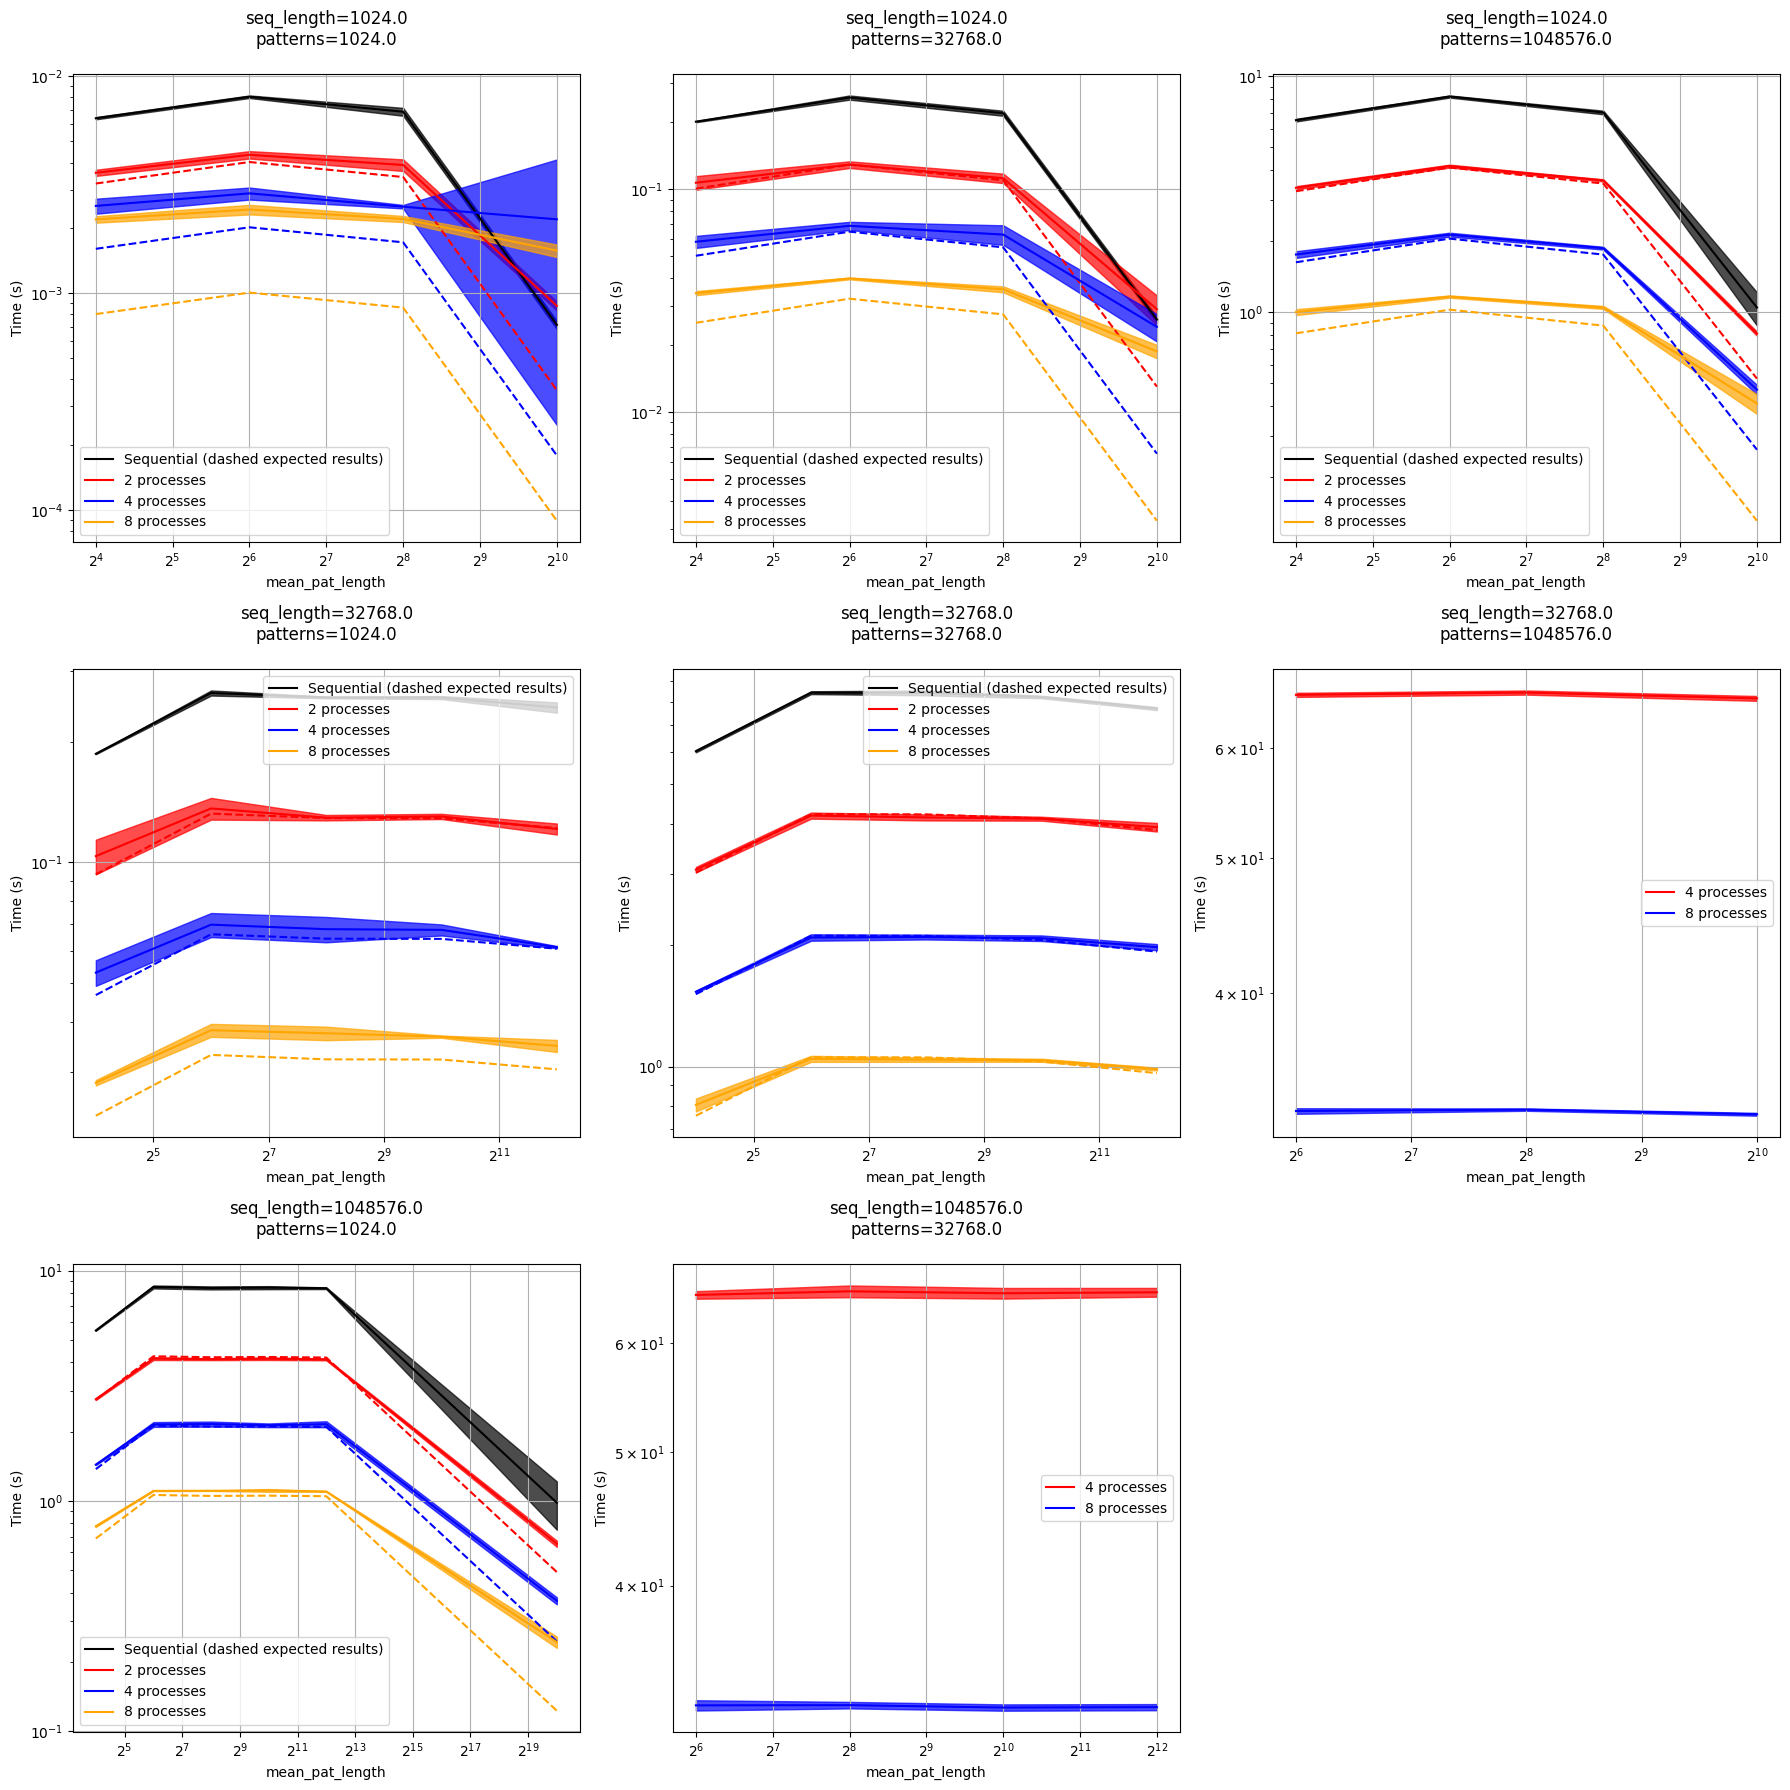

In [20]:
plot_variable_sequential_mpi("mean_pat_length")

## MPI+PThreads

In [115]:
def plot_variable_sequential_mpi_pthreads(variable):
    """
    This function creates plots of mpi+pthreads and sequential corresponding to the arrays created in comparison.
    Check comparison's description for a thorough explanation.

    Input:
     - variable: the variable we are comparing on

    Output:
     - a multifaceted graph of time vs variable, where each facet is a fixed configuration
       of the other variables (again, check comparison's description)
    """
    # Grouping measurements by fixing all the other variables but the chosen one
    # Check sequntial_vs_mpi for more info
    data = comparison_seq_pthreads(sequential, mpi_pthreads, idx, variable)

    # Setting up the plots
    side = ceil(len(data) ** 0.5)
    fig, axis = plt.subplots(side, side)

    # Fixing the interesting indexes
    seq_idx = idx[variable]
    mpi_idx = idx[variable] + 2

    # Axis index
    fig_idx = 0
    last_idx = side**2 - 1

    # Colour dictionary
    colours = {(4, 2): "red", (4, 4): "orange", (4, 8): "green", (8, 2): "aqua", (8, 4): "blue", (8, 8): "indigo"}

    # Removing plots that are exceeding
    while (last_idx >= len(data)):
        axis[last_idx//side][last_idx%side].remove()
        last_idx -= 1

    # Flag signaling that the present configuration has been plotted
    # This is useful for counting the number of plots
    flag = False

    # Plotting each and every grouping
    for const, seq, mpi in data:
        # Ordering groupings by the interesting variable
        #seq = seq[np.argsort(seq[:,seq_idx])]
        #pth = pth[np.argsort(pth[:,pth_idx])]
          
        # Plotting the sequential datapoints for the chosen grouping
        if seq.shape[0] >= 2:
            axis[int(fig_idx/side)][fig_idx%side].plot(seq[:, seq_idx], seq[:, -1], color='black', label = "Sequential (dashed expected results)")
            
            # Plotting a 95% ci 
            span = 1.96 * seq[:, -2]
            lower_ci = seq[:, -1] - span
            upper_ci = seq[:, -1] + span
            axis[int(fig_idx/side)][fig_idx%side].fill_between(seq[:, seq_idx], lower_ci, upper_ci, alpha = 0.7, color = "black")
            
            # Notifying that this figure has at least a line
            flag = True

        # Plotting the mpi+pthreads datapoints for the chosen grouping:
        # We need to group again on each process+thread number
        # THIS PART MUST BE CHANGED IF THE NUMBER OF VARIABLES CHANGES
        for j in sorted(set(mpi[:, 0])):
            for k in sorted(set(mpi[:, 1])):
                mpi_group = mpi[(mpi[:, 0] == j) & (mpi[:, 1] == k)]
                if mpi_group.shape[0] >= 2:
                    mpi_label = str(int(mpi_group[0, 0])) + " processes\n" + str(int(mpi_group[0, 1])) + " threads"
                    
                    axis[int(fig_idx/side)][fig_idx%side].plot(mpi_group[:, mpi_idx], mpi_group[:, -1], color=colours[(j, k)], label = mpi_label)
                
                    # Plotting a 95% ci 
                    span = 1.96 * mpi_group[:, -2]
                    lower_ci = mpi_group[:, -1] - span
                    upper_ci = mpi_group[:, -1] + span

                    axis[int(fig_idx/side)][fig_idx%side].fill_between(mpi_group[:, mpi_idx], lower_ci, upper_ci, alpha = 0.7, color = colours[(j, k)])
                    
                    # Notifying that this figure has at least a line
                    flag = True

        # Finishing the plot or notifying the reason of its absence
        title = ""
        i = 0
        for k in idx.keys():
            if k != variable and k != "mean_time" and k != "time_std":
                title += k + "=" + str(const[i]) + "\n"
                i += 1
        
        if flag:
            axis[int(fig_idx/side)][fig_idx%side].set_title(title)
            axis[int(fig_idx/side)][fig_idx%side].set_xlabel(variable)
            axis[int(fig_idx/side)][fig_idx%side].set_ylabel('Time (s)')
            axis[int(fig_idx/side)][fig_idx%side].set_yscale('log')
            axis[int(fig_idx/side)][fig_idx%side].set_xscale('log', base = 2)
            axis[int(fig_idx/side)][fig_idx%side].legend()
            axis[int(fig_idx/side)][fig_idx%side].grid()
            flag = False
            fig_idx += 1
        else:
            print("This configuration has not been print:")
            print(title)
            print(f"Number of sequential datapoints: {seq.shape[0]}")
            print(f"Number of MPI+PThreads datapoints: {mpi.shape[0]}")
            print("------------------------------------------------")
            
            # Removing unused axes
            axis[last_idx//side][last_idx%side].remove()
            last_idx -= 1
                    
    fig.set_figheight(side*6)
    fig.set_figwidth(side*6)
    plt.tight_layout()
    plt.show()

For configuration [1024.], there was not enough data.
Sequential data: 1
Parallel data: 1
For configuration [4096.], there was not enough data.
Sequential data: 0
Parallel data: 1
For configuration [16.], there was not enough data.
Sequential data: 0
Parallel data: 1
For configuration [256.], there was not enough data.
Sequential data: 0
Parallel data: 1
This configuration has not been print:
patterns=32768.0
mean_pat_length=4096.0

Number of sequential datapoints: 1
Number of MPI+PThreads datapoints: 5
------------------------------------------------
This configuration has not been print:
patterns=1048576.0
mean_pat_length=16.0

Number of sequential datapoints: 1
Number of MPI+PThreads datapoints: 6
------------------------------------------------
This configuration has not been print:
patterns=1048576.0
mean_pat_length=64.0

Number of sequential datapoints: 1
Number of MPI+PThreads datapoints: 5
------------------------------------------------


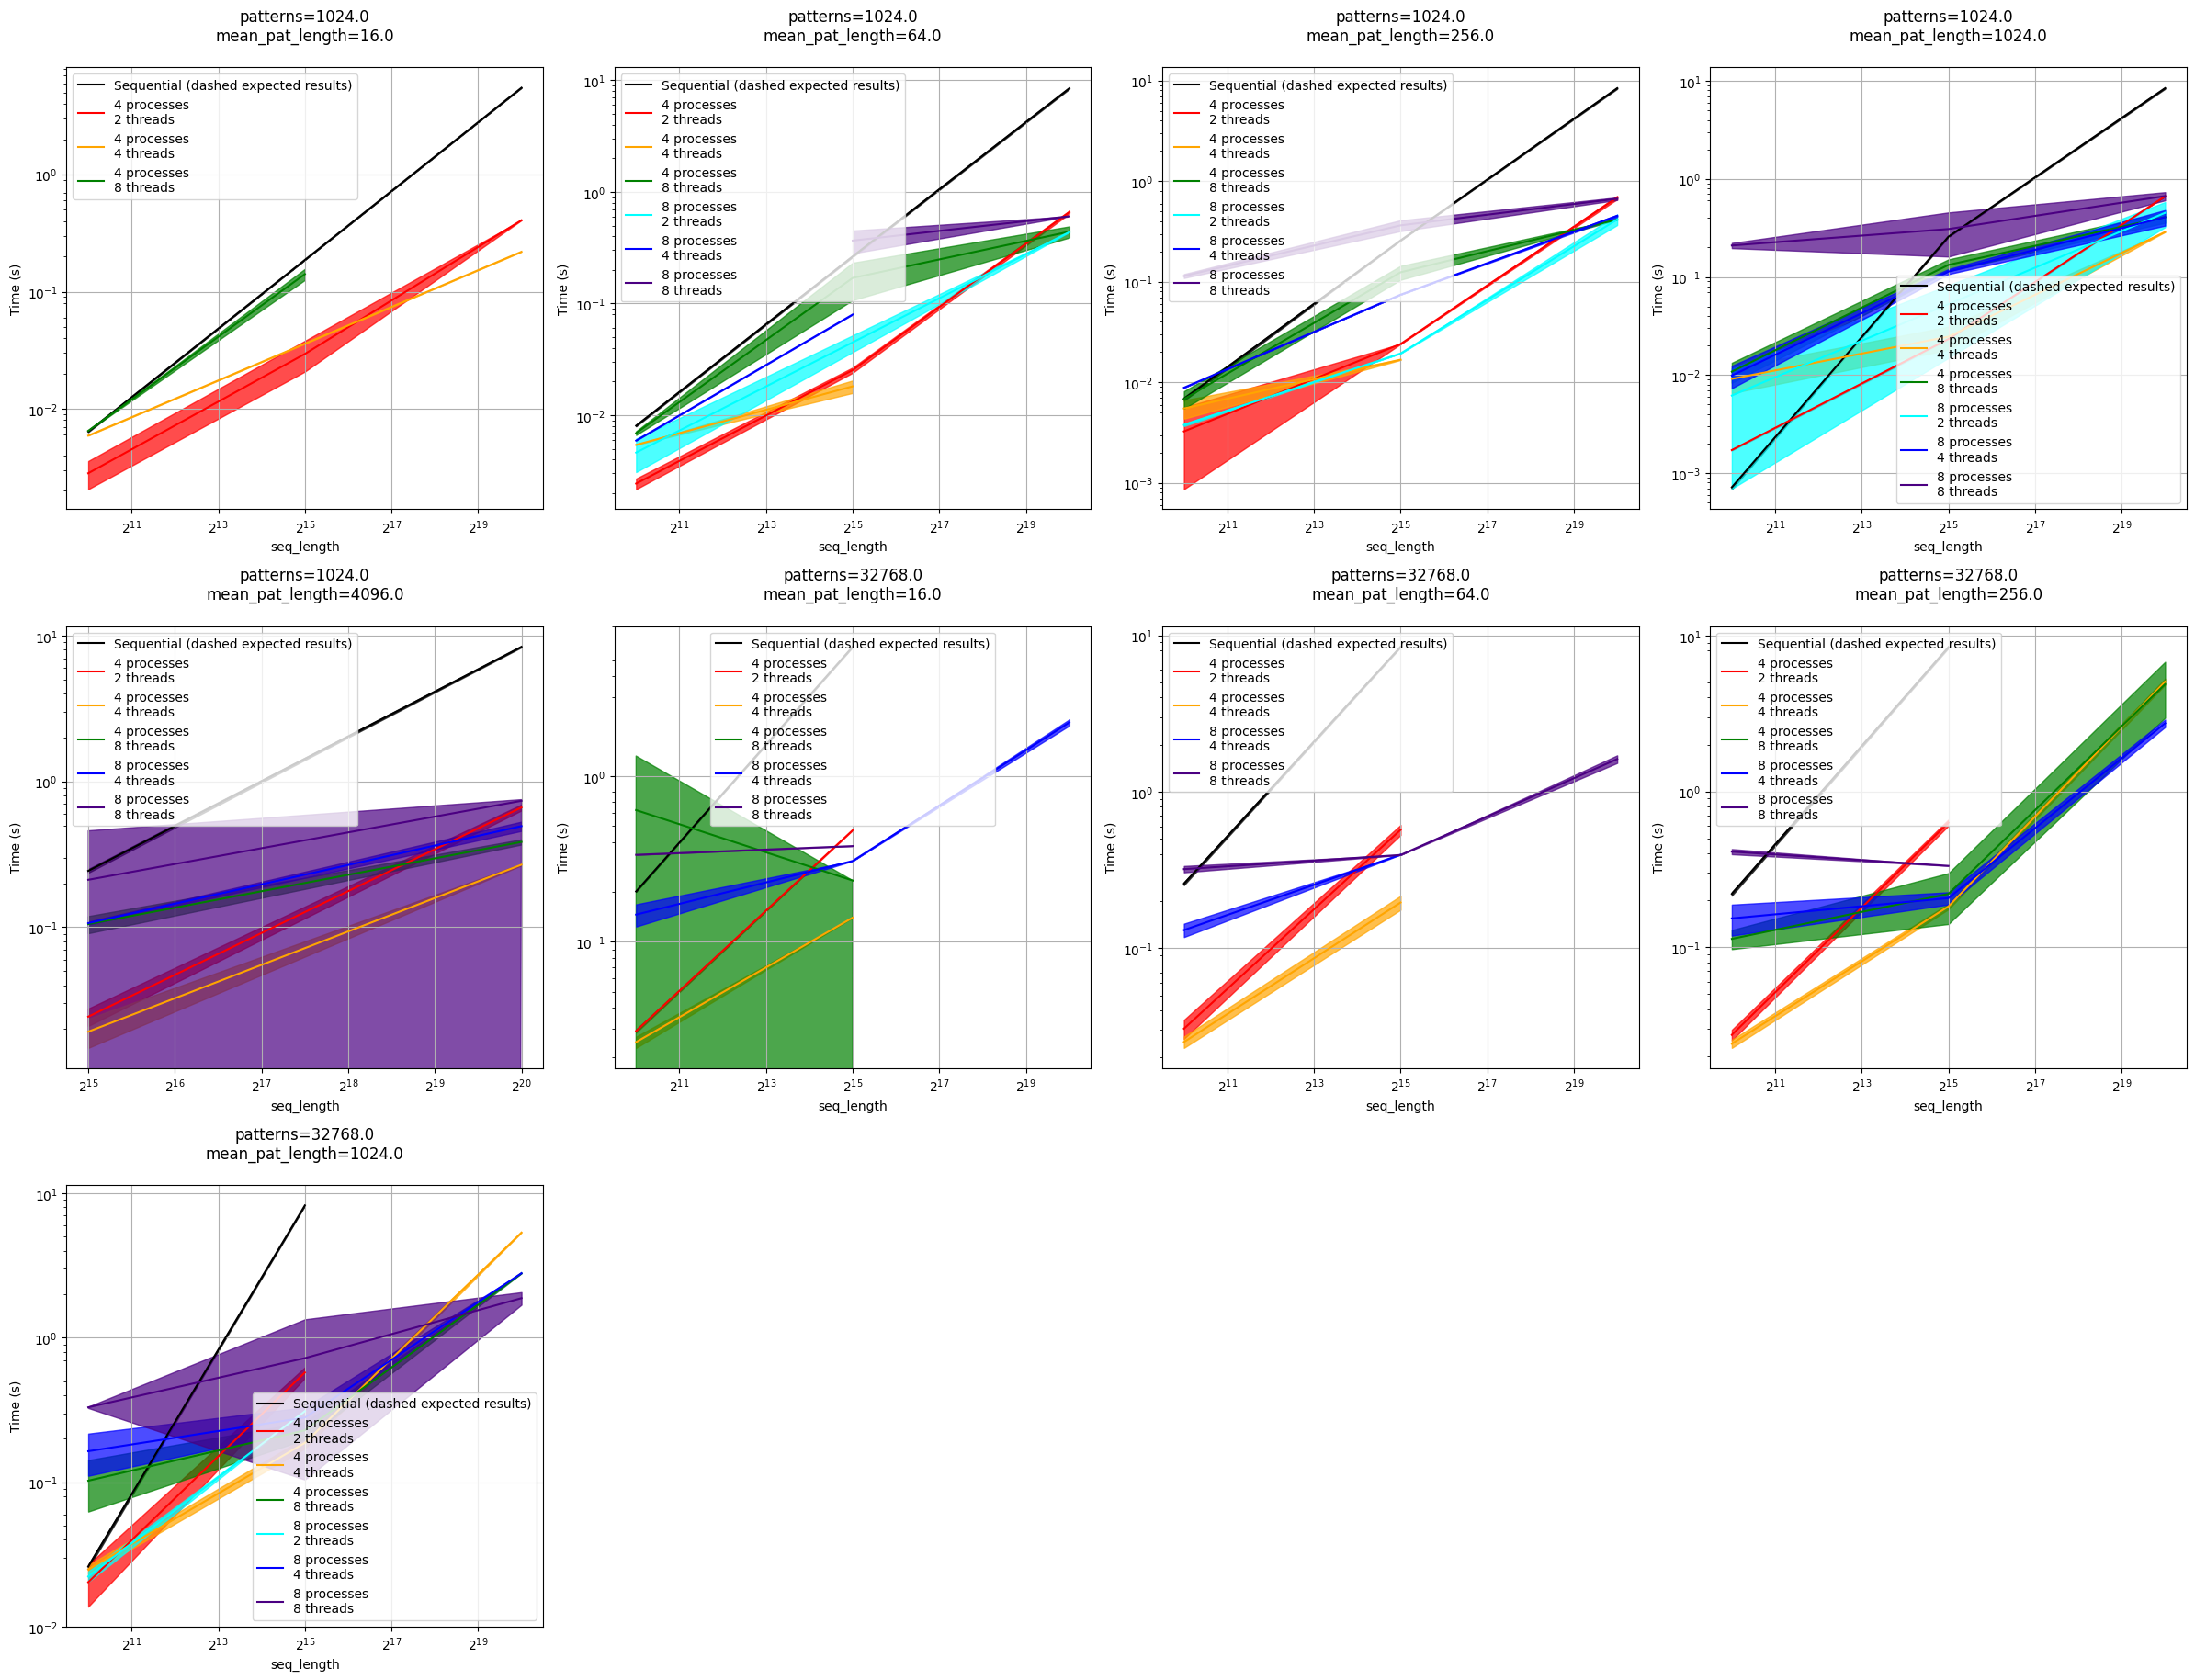

In [116]:
plot_variable_sequential_mpi_pthreads("seq_length")

# Times table

In [21]:
def times(variable, parallel):
    '''
    For each parallel test, it prints the times of the sequential counterpart and all the parallel ones.
    The times are confronted on a specific variable, while the other settings are kept constant.

    Input:
     - variable: the variable where the comparison takes place; either seq_length, patterns, or mean_path_length
     - parallel: the name of the parallel version we are testing, either pthreads or mpi

    Output: 
     - a series of printed panda dataframes, each for a specific configuration setting
    '''
    # Choosing the type of parallel data
    if parallel == "pthreads":
        data = sequential_vs_pthreads(variable)
        unit = "Threads"
    elif parallel == "mpi":
        data = sequential_vs_mpi(variable)
        unit = "Cores"

    # Extracting data for each configuration
    for config, seq, par in data:
        
        # Creating the title of the configuration
        title = f"Sequential vs {parallel} on {variable} for fixed\n"
        i = 0
        for k in idx.keys():
            if k != variable and k != "mean_time" and k != "time_std":
                title += k + "=" + str(config[i]) + "\n"
                i += 1
        print(title)

        # Creating the table
        units = np.append([1], sorted(set(par[:, 0]))).astype(dtype = np.int8)
        table = {unit: units}
        df = pd.DataFrame(table)

        measurements = sorted(set(par[:, idx[variable] + 1]))
        for i in measurements:
            df[i] = np.nan
        df = df.rename(index={i: x for i, x in enumerate(units)})
        df = df.drop(columns=unit)

        # Adding measurements
        for i in units:
            for j in df.columns:
                if i == 1:
                    # Checking that the specific test has ben run on this version
                    record = seq[seq[:, idx[variable]] == j]
                    if len(record) > 0:
                        df.loc[i, j] = record[:, -1].item()
                else:
                    # Checking that the specific test has ben run on this version
                    record = par[np.where((par[:, 0] == i) & (par[:, idx[variable] + 1] == j))]
                    if len(record) > 0:
                        df.loc[i, j] = record[:, -1].item()

        print(df)
        print("------------------------------------------------------------------------")

In [210]:
def times_mpipthreads(variable):
    '''
    For each parallel test, it prints the times of the sequential counterpart and all the parallel ones.
    The times are confronted on a specific variable, while the other settings are kept constant.

    Input:
     - variable: the variable where the comparison takes place; either seq_length, patterns, or mean_path_length
     - parallel: the name of the parallel version we are testing, either pthreads or mpi

    Output: 
     - a series of printed panda dataframes, each for a specific configuration setting
    '''
    # Saving data as panda dataframes
    seq_data = sequential
    par_data = mpi_pthreads
    seq = pd.DataFrame(seq_data)
    par = pd.DataFrame(par_data)

    # Renaming columns correctly
    seq.rename(columns={0: "seq_length", 1: "patterns", 2: "mean_pat_length", 3: "time_std", 4: "mean_time"}, inplace=True)
    par.rename(columns={0: "processes", 1: "threads", 2: "seq_length", 3: "patterns", 4: "mean_pat_length", 5: "time_std", 6: "mean_time"}, inplace=True)

    # Adding columns to sequential in such a way we can perform the join
    seq.insert(0, column="threads", value=1)
    seq.insert(0, column="processes", value=1)
    
    # Performing the merge
    result = seq.merge(par, how='inner', on=["seq_length", "patterns", "mean_pat_length"])
    result.sort_values(by = ['seq_length', 'patterns', 'mean_pat_length'], inplace=True)
    result["mean_time_y"] = result["mean_time_x"]/result["mean_time_y"]

    result.drop(columns=["processes_x", "threads_x", "time_std_x", "mean_time_x"], inplace=True)
    result.rename(columns={"processes_y": "processes", "threads_y": "threads", "time_std_y": "time_std", "mean_time_y": "speedup"}, inplace=True)
    result = result[["processes", "threads", "seq_length", "patterns", "mean_pat_length", "time_std", "speedup"]]
    result.sort_values(by = ['patterns', 'mean_pat_length', 'processes', 'threads', 'seq_length'], inplace=True)

    print(result.to_string())

In [211]:
times_mpipthreads("patterns")

     processes  threads  seq_length   patterns  mean_pat_length  time_std    speedup
0          4.0      2.0      1024.0     1024.0             16.0  0.000388   2.266797
54         4.0      2.0     32768.0     1024.0             16.0  0.004408   6.341865
104        4.0      2.0   1048576.0     1024.0             16.0  0.000000  13.508076
1          4.0      4.0      1024.0     1024.0             16.0  0.000000   1.082961
105        4.0      4.0   1048576.0     1024.0             16.0  0.000000  25.101559
2          4.0      8.0      1024.0     1024.0             16.0  0.000000   0.985268
55         4.0      8.0     32768.0     1024.0             16.0  0.007779   1.322979
56         8.0      4.0     32768.0     1024.0             16.0  0.000000   1.774160
57         8.0      8.0     32768.0     1024.0             16.0  0.019517   0.521528
3          4.0      2.0      1024.0     1024.0             64.0  0.000136   3.301868
58         4.0      2.0     32768.0     1024.0             64.0  

# Efficiency table

In [23]:
def efficiency(variable, parallel):
    '''
    For each sequential test, it prints the efficiency of a relative parallel version.
    The efficiency rates are confronted on a specific variable, while the other settings are kept constant.

    Input:
     - variable: the variable where the comparison takes place; either seq_length, patterns, or mean_path_length
     - parallel: the name of the parallel version we are testing, either pthreads or mpi

    Output: 
     - a series of printed panda dataframes, each for a specific configuration setting
    '''
    # Choosing the type of parallel data
    if parallel == "pthreads":
        data = sequential_vs_pthreads(variable)
        unit = "Threads"
    elif parallel == "mpi":
        data = sequential_vs_mpi(variable)
        unit = "Processes"

    # Extracting data for each configuration
    for config, seq, par in data:
        
        # Creating the title of the configuration
        title = f"Sequential vs {parallel} on {variable} for fixed\n"
        i = 0
        for k in idx.keys():
            if k != variable and k != "mean_time" and k != "time_std":
                title += k + "=" + str(config[i]) + "\n"
                i += 1
        print(title)

        # Creating the table
        units = np.append([1], sorted(set(par[:, 0]))).astype(dtype = np.int8)
        table = {unit: units}
        df = pd.DataFrame(table)

        measurements = seq[:, idx[variable]]
        for i in measurements:
            df[i] = np.nan
        df = df.rename(index={i: x for i, x in enumerate(units)})
        df = df.drop(columns=unit)

        # Adding measurements
        for i in units:
            if i == 1:
                df.loc[i] = seq[:, -1]
            else:
                for j in df.columns:
                    record = par[np.where((par[:, 0] == i) & (par[:, idx[variable] + 1] == j))]
                    if len(record) > 0:
                        # Checking that the specific test has ben run on this version
                        df.loc[i, j] = record[:, -1].item()

        # Normalization
        for i in units[::-1]:
            df.loc[i] = df.loc[1] / (i * df.loc[i])

        print(df)
        print("------------------------------------------------------------------------")

In [24]:
efficiency("mean_pat_length", "mpi")

Sequential vs mpi on mean_pat_length for fixed
seq_length=1024.0
patterns=1024.0

       16.0      64.0     256.0    1024.0
1  1.000000  1.000000  1.000000  1.000000
2  0.892351  0.925908  0.879937  0.408565
4  0.634296  0.697459  0.684906  0.081536
8  0.365932  0.413940  0.390188  0.056801
------------------------------------------------------------------------
Sequential vs mpi on mean_pat_length for fixed
seq_length=1024.0
patterns=32768.0

       16.0      64.0     256.0    1024.0
1  1.000000  1.000000  1.000000  1.000000
2  0.940319  1.000080  0.979190  0.449516
4  0.865226  0.941539  0.876677  0.269680
8  0.735824  0.811202  0.771549  0.173604
------------------------------------------------------------------------
Sequential vs mpi on mean_pat_length for fixed
seq_length=1024.0
patterns=1048576.0

       16.0      64.0     256.0    1024.0
1  1.000000  1.000000  1.000000  1.000000
2  0.966878  0.985443  0.969591  0.644924
4  0.927472  0.961663  0.939485  0.556853
8  0.813038  0.8

# Saving final results


## Support functions

In [27]:
def final_dataset(paradigm):
    match paradigm:
        case "sequential":
            dataset = create_dataset("results/logs/sequential", len(idx))
        case "pthreads":
            dataset =  create_dataset("results/logs/pthreads", len(idx) + 1, first_setting_column=1)
        case "mpi/simple":
            dataset = create_dataset("results/logs/mpi", len(idx) + 1, first_setting_column=1, outname = "job.out.0")
        case "mpi/improved":
            dataset = create_dataset("results/logs/mpi_exp", len(idx) + 1, first_setting_column=1, outname = "job.out.0")
        case "mpi/broadcast":
            dataset = create_dataset("results/logs/mpi_bcast", len(idx) + 1, first_setting_column=1, outname = "job.out.0")
        case _:
            print("Error in paradigm input")
            return
    
    return dataset

In [73]:
def final_efficiency(variable, parallel):
    '''
    For each sequential test, it prints the efficiency of a relative parallel version.
    The efficiency rates are confronted on a specific variable, while the other settings are kept constant.

    Input:
     - variable: the variable where the comparison takes place; either seq_length, patterns, or mean_path_length
     - parallel: the name of the parallel version we are testing, either pthreads or mpi

    Output: 
     - a series of printed panda dataframes, each for a specific configuration setting
    '''
    # Choosing the type of parallel data
    if parallel == "pthreads":
        data = comparison_mod(final_dataset("sequential"), final_dataset("pthreads"), idx, variable)
        unit = "Threads"
    elif parallel == "mpi":
        data = comparison_mod(final_dataset("sequential"), final_dataset("mpi/simple"), idx, variable)
        unit = "Processes"
    elif parallel == "mpi_bcast":
        data = comparison_mod(final_dataset("sequential"), final_dataset("mpi/broadcast"), idx, variable)
        unit = "Processes"
    elif parallel == "mpi_exp":
        data = comparison_mod(final_dataset("sequential"), final_dataset("mpi/improved"), idx, variable)
        unit = "Processes"

    # Extracting data for each configuration
    for config, seq, par in data:
        
        # Creating the title of the configuration
        title = f"Sequential vs {parallel} on {variable} for fixed\n"
        i = 0
        for k in idx.keys():
            if k != variable and k != "mean_time" and k != "time_std":
                title += k + "=" + str(config[i]) + "\n"
                i += 1
        print(title)

        # Creating the table
        units = np.append([1], sorted(set(par[:, 0]))).astype(dtype = np.int8)
        table = {unit: units}
        df = pd.DataFrame(table)

        measurements = seq[:, idx[variable]]
        for i in measurements:
            df[i] = np.nan
        df = df.rename(index={i: x for i, x in enumerate(units)})
        df = df.drop(columns=unit)

        # Adding measurements
        for i in units:
            if i == 1:
                df.loc[i] = seq[:, -1]
            else:
                for j in df.columns:
                    record = par[np.where((par[:, 0] == i) & (par[:, idx[variable] + 1] == j))]
                    if len(record) > 0:
                        # Checking that the specific test has ben run on this version
                        df.loc[i, j] = record[:, -1].item()

        # Normalization
        for i in units[::-1]:
            df.loc[i] = df.loc[1] / (i * df.loc[i])

        print(df)
        print("------------------------------------------------------------------------")

## Times

In [28]:
def write_dataset(paradigm):
    dataset = final_dataset(paradigm)
    with open(f"final_folder/results/{paradigm}/times.txt", 'w') as f:
        f.write("\n".join(map(str, dataset)))

In [41]:
write_dataset("mpi/improved")

## Plots

In [26]:
def save_plot_variable_sequential_pthreads(variable):
    """
    This function creates plots of pthreads and sequential corresponding to the arrays created in comparison.
    Check comparison's description for a thorough explanation.

    Input:
     - variable: the variable we are comparing on

    Output:
     - a multifaceted graph of time vs variable, where each facet is a fixed configuration
       of the other variables (again, check comparison's description)
    """
    # Grouping measurements by fixing all the other variables but the chosen one
    # Check sequntial_vs_pthreads for more info
    data = comparison_mod(final_dataset("sequential"), final_dataset("pthreads"), idx, variable)  

    # Setting up the plots
    side = ceil(len(data) ** 0.5)
    fig, axis = plt.subplots(side, side)

    # Fixing the interesting indexes
    seq_idx = idx[variable]
    pth_idx = idx[variable] + 1

    # Axis index
    fig_idx = 0
    last_idx = side**2 - 1

    # Removing plots that are exceeding
    while (last_idx >= len(data)):
        axis[last_idx//side][last_idx%side].remove()
        last_idx -= 1

    # Flag signaling that the present configuration has been plotted
    # This is useful for counting the number of plots
    flag = False

    # Plotting each and every grouping
    for const, seq, pth in data:
        # Ordering groupings by the interesting variable
        #seq = seq[np.argsort(seq[:,seq_idx])]
        #pth = pth[np.argsort(pth[:,pth_idx])]
          
        # Plotting the sequential datapoints for the chosen grouping
        if seq.shape[0] >= 2:
            axis[int(fig_idx/side)][fig_idx%side].plot(seq[:, seq_idx], seq[:, -1], color='black', label = "Sequential (dashed expected results)")
            
            # Plotting a 95% ci 
            span = 1.96 * seq[:, -2]
            lower_ci = seq[:, -1] - span
            upper_ci = seq[:, -1] + span
            axis[int(fig_idx/side)][fig_idx%side].fill_between(seq[:, seq_idx], lower_ci, upper_ci, alpha = 0.7, color = "black")
            
            # Plotting the expected parallel speedup for the chosen grouping
            for num_cores, colour in zip((sorted(set(pth[:, 0]))), ("red", "blue", "orange", "green")):
                exp_label = "Expected speedup for " + str(int(num_cores)) + " threads"
                def speedup(time):
                    return time/num_cores
                exp_par_time = np.apply_along_axis(speedup, 0, seq[:, -1])

                axis[int(fig_idx/side)][fig_idx%side].plot(seq[:, seq_idx], exp_par_time, color=colour, ls = "--")
            
            # Notifying that this figure has at least a line
            flag = True

        # Plotting the pthreads datapoints for the chosen grouping:
        # We need to group again on each thread number
        # THIS PART MUST BE CHANGED IF THE NUMBER OF VARIABLES CHANGES
        for j, colour in zip(sorted(set(pth[:, 0])), ("red", "blue", "orange", "green")):
            pth_group = pth[pth[:, 0] == j]
            if pth_group.shape[0] >= 2:
                pth_label = str(int(pth_group[0, 0])) + " threads"

                axis[int(fig_idx/side)][fig_idx%side].plot(pth_group[:, pth_idx], pth_group[:, -1], color=colour, label = pth_label)
            
                # Plotting a 95% ci 
                span = 1.96 * pth_group[:, -2]
                lower_ci = pth_group[:, -1] - span
                upper_ci = pth_group[:, -1] + span

                axis[int(fig_idx/side)][fig_idx%side].fill_between(pth_group[:, pth_idx], lower_ci, upper_ci, alpha = 0.7, color = colour)
                
                # Notifying that this figure has at least a line
                flag = True

        # Finishing the plot or notifying the reason of its absence
        title = ""
        i = 0
        for k in idx.keys():
            if k != variable and k != "mean_time" and k != "time_std":
                title += k + "=" + str(const[i]) + "\n"
                i += 1
        
        if flag:
            axis[int(fig_idx/side)][fig_idx%side].set_title(title)
            axis[int(fig_idx/side)][fig_idx%side].set_xlabel(variable)
            axis[int(fig_idx/side)][fig_idx%side].set_ylabel('Time (s)')
            axis[int(fig_idx/side)][fig_idx%side].set_yscale('log')
            axis[int(fig_idx/side)][fig_idx%side].set_xscale('log', base = 2)
            axis[int(fig_idx/side)][fig_idx%side].legend()
            axis[int(fig_idx/side)][fig_idx%side].grid()
            flag = False
            fig_idx += 1
        else:
            print("This configuration has not been print:")
            print(title)
            print(f"Number of sequential datapoints: {seq.shape[0]}")
            print(f"Number of PThreads datapoints: {pth.shape[0]}")
            print("------------------------------------------------")
            
            # Removing unused axes
            axis[last_idx//side][last_idx%side].remove()
            last_idx -= 1
                    
    fig.set_figheight(side*6)
    fig.set_figwidth(side*6)
    plt.tight_layout()
    plt.savefig(f"final_folder/results/pthreads/{variable}.png")

For configuration [33554432.], there was not enough data.
Sequential data: 0
Parallel data: 1


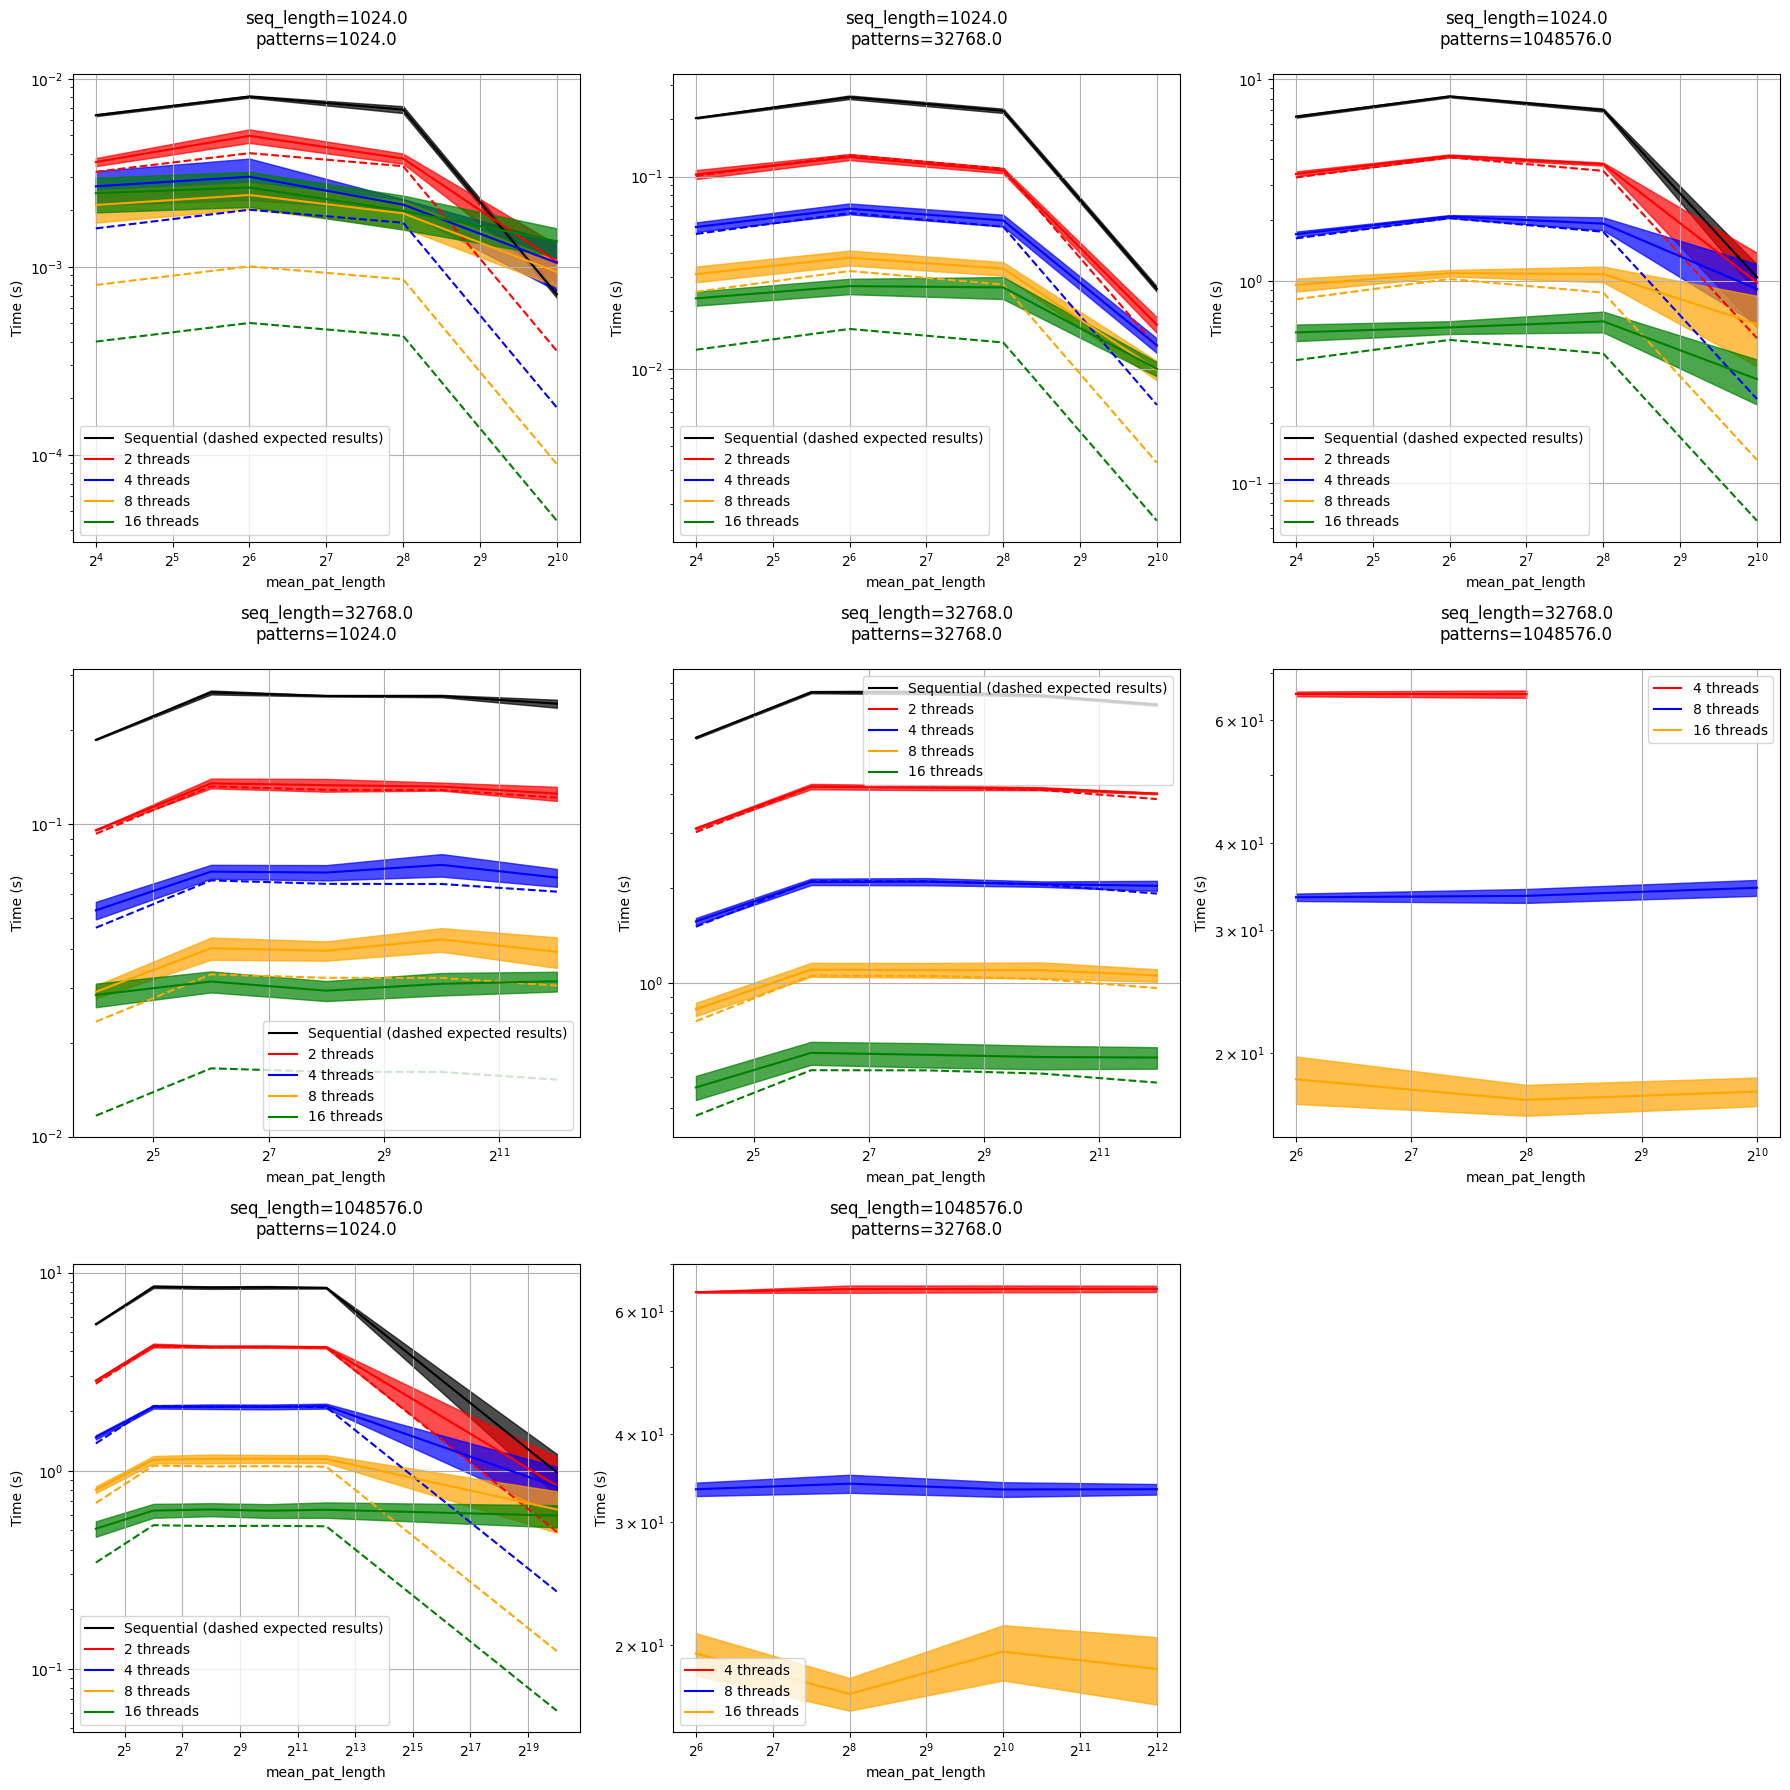

In [44]:
save_plot_variable_sequential_pthreads("mean_pat_length")

In [37]:
def save_plot_variable_sequential_mpi(path, variable):
    """
    This function creates plots of mpi and sequential corresponding to the arrays created in comparison.
    Check comparison's description for a thorough explanation.

    Input:
     - variable: the variable we are comparing on

    Output:
     - a multifaceted graph of time vs variable, where each facet is a fixed configuration
       of the other variables (again, check comparison's description)
    """
    # Grouping measurements by fixing all the other variables but the chosen one
    # Check sequntial_vs_mpi for more info
    data = comparison_mod(final_dataset("sequential"), final_dataset(path), idx, variable)  

    # Setting up the plots
    side = ceil(len(data) ** 0.5)
    fig, axis = plt.subplots(side, side)

    # Fixing the interesting indexes
    seq_idx = idx[variable]
    mpi_idx = idx[variable] + 1

    # Axis index
    fig_idx = 0
    last_idx = side**2 - 1

    # Removing plots that are exceeding
    while (last_idx >= len(data)):
        axis[last_idx//side][last_idx%side].remove()
        last_idx -= 1

    # Flag signaling that the present configuration has been plotted
    # This is useful for counting the number of plots
    flag = False

    # Plotting each and every grouping
    for const, seq, mpi in data:
        # Ordering groupings by the interesting variable
        #seq = seq[np.argsort(seq[:,seq_idx])]
        #pth = pth[np.argsort(pth[:,pth_idx])]
          
        # Plotting the sequential datapoints for the chosen grouping
        if seq.shape[0] >= 2:
            axis[int(fig_idx/side)][fig_idx%side].plot(seq[:, seq_idx], seq[:, -1], color='black', label = "Sequential (dashed expected results)")
            
            # Plotting a 95% ci 
            span = 1.96 * seq[:, -2]
            lower_ci = seq[:, -1] - span
            upper_ci = seq[:, -1] + span
            axis[int(fig_idx/side)][fig_idx%side].fill_between(seq[:, seq_idx], lower_ci, upper_ci, alpha = 0.7, color = "black")
            
            # Plotting the expected parallel speedup for the chosen grouping
            for num_cores, colour in zip((sorted(set(mpi[:, 0]))), ("red", "blue", "orange", "green")):
                exp_label = "Expected speedup for " + str(int(num_cores)) + " processes"
                def speedup(time):
                    return time/num_cores
                exp_par_time = np.apply_along_axis(speedup, 0, seq[:, -1])

                axis[int(fig_idx/side)][fig_idx%side].plot(seq[:, seq_idx], exp_par_time, color=colour, ls = "--")
            
            # Notifying that this figure has at least a line
            flag = True

        # Plotting the mpi datapoints for the chosen grouping:
        # We need to group again on each process number
        # THIS PART MUST BE CHANGED IF THE NUMBER OF VARIABLES CHANGES
        for j, colour in zip(sorted(set(mpi[:, 0])), ("red", "blue", "orange", "green")):
            mpi_group = mpi[mpi[:, 0] == j]
            if mpi_group.shape[0] >= 2:
                mpi_label = str(int(mpi_group[0, 0])) + " processes"

                axis[int(fig_idx/side)][fig_idx%side].plot(mpi_group[:, mpi_idx], mpi_group[:, -1], color=colour, label = mpi_label)
            
                # Plotting a 95% ci 
                span = 1.96 * mpi_group[:, -2]
                lower_ci = mpi_group[:, -1] - span
                upper_ci = mpi_group[:, -1] + span

                axis[int(fig_idx/side)][fig_idx%side].fill_between(mpi_group[:, mpi_idx], lower_ci, upper_ci, alpha = 0.7, color = colour)
                
                # Notifying that this figure has at least a line
                flag = True

        # Finishing the plot or notifying the reason of its absence
        title = ""
        i = 0
        for k in idx.keys():
            if k != variable and k != "mean_time" and k != "time_std":
                title += k + "=" + str(const[i]) + "\n"
                i += 1
        
        if flag:
            axis[int(fig_idx/side)][fig_idx%side].set_title(title)
            axis[int(fig_idx/side)][fig_idx%side].set_xlabel(variable)
            axis[int(fig_idx/side)][fig_idx%side].set_ylabel('Time (s)')
            axis[int(fig_idx/side)][fig_idx%side].set_yscale('log')
            axis[int(fig_idx/side)][fig_idx%side].set_xscale('log', base = 2)
            axis[int(fig_idx/side)][fig_idx%side].legend()
            axis[int(fig_idx/side)][fig_idx%side].grid()
            flag = False
            fig_idx += 1
        else:
            print("This configuration has not been print:")
            print(title)
            print(f"Number of sequential datapoints: {seq.shape[0]}")
            print(f"Number of MPI datapoints: {mpi.shape[0]}")
            print("------------------------------------------------")
            
            # Removing unused axes
            axis[last_idx//side][last_idx%side].remove()
            last_idx -= 1
                    
    fig.set_figheight(side*6)
    fig.set_figwidth(side*6)
    plt.tight_layout()
    plt.savefig(f"final_folder/results/{path}/{variable}.png")

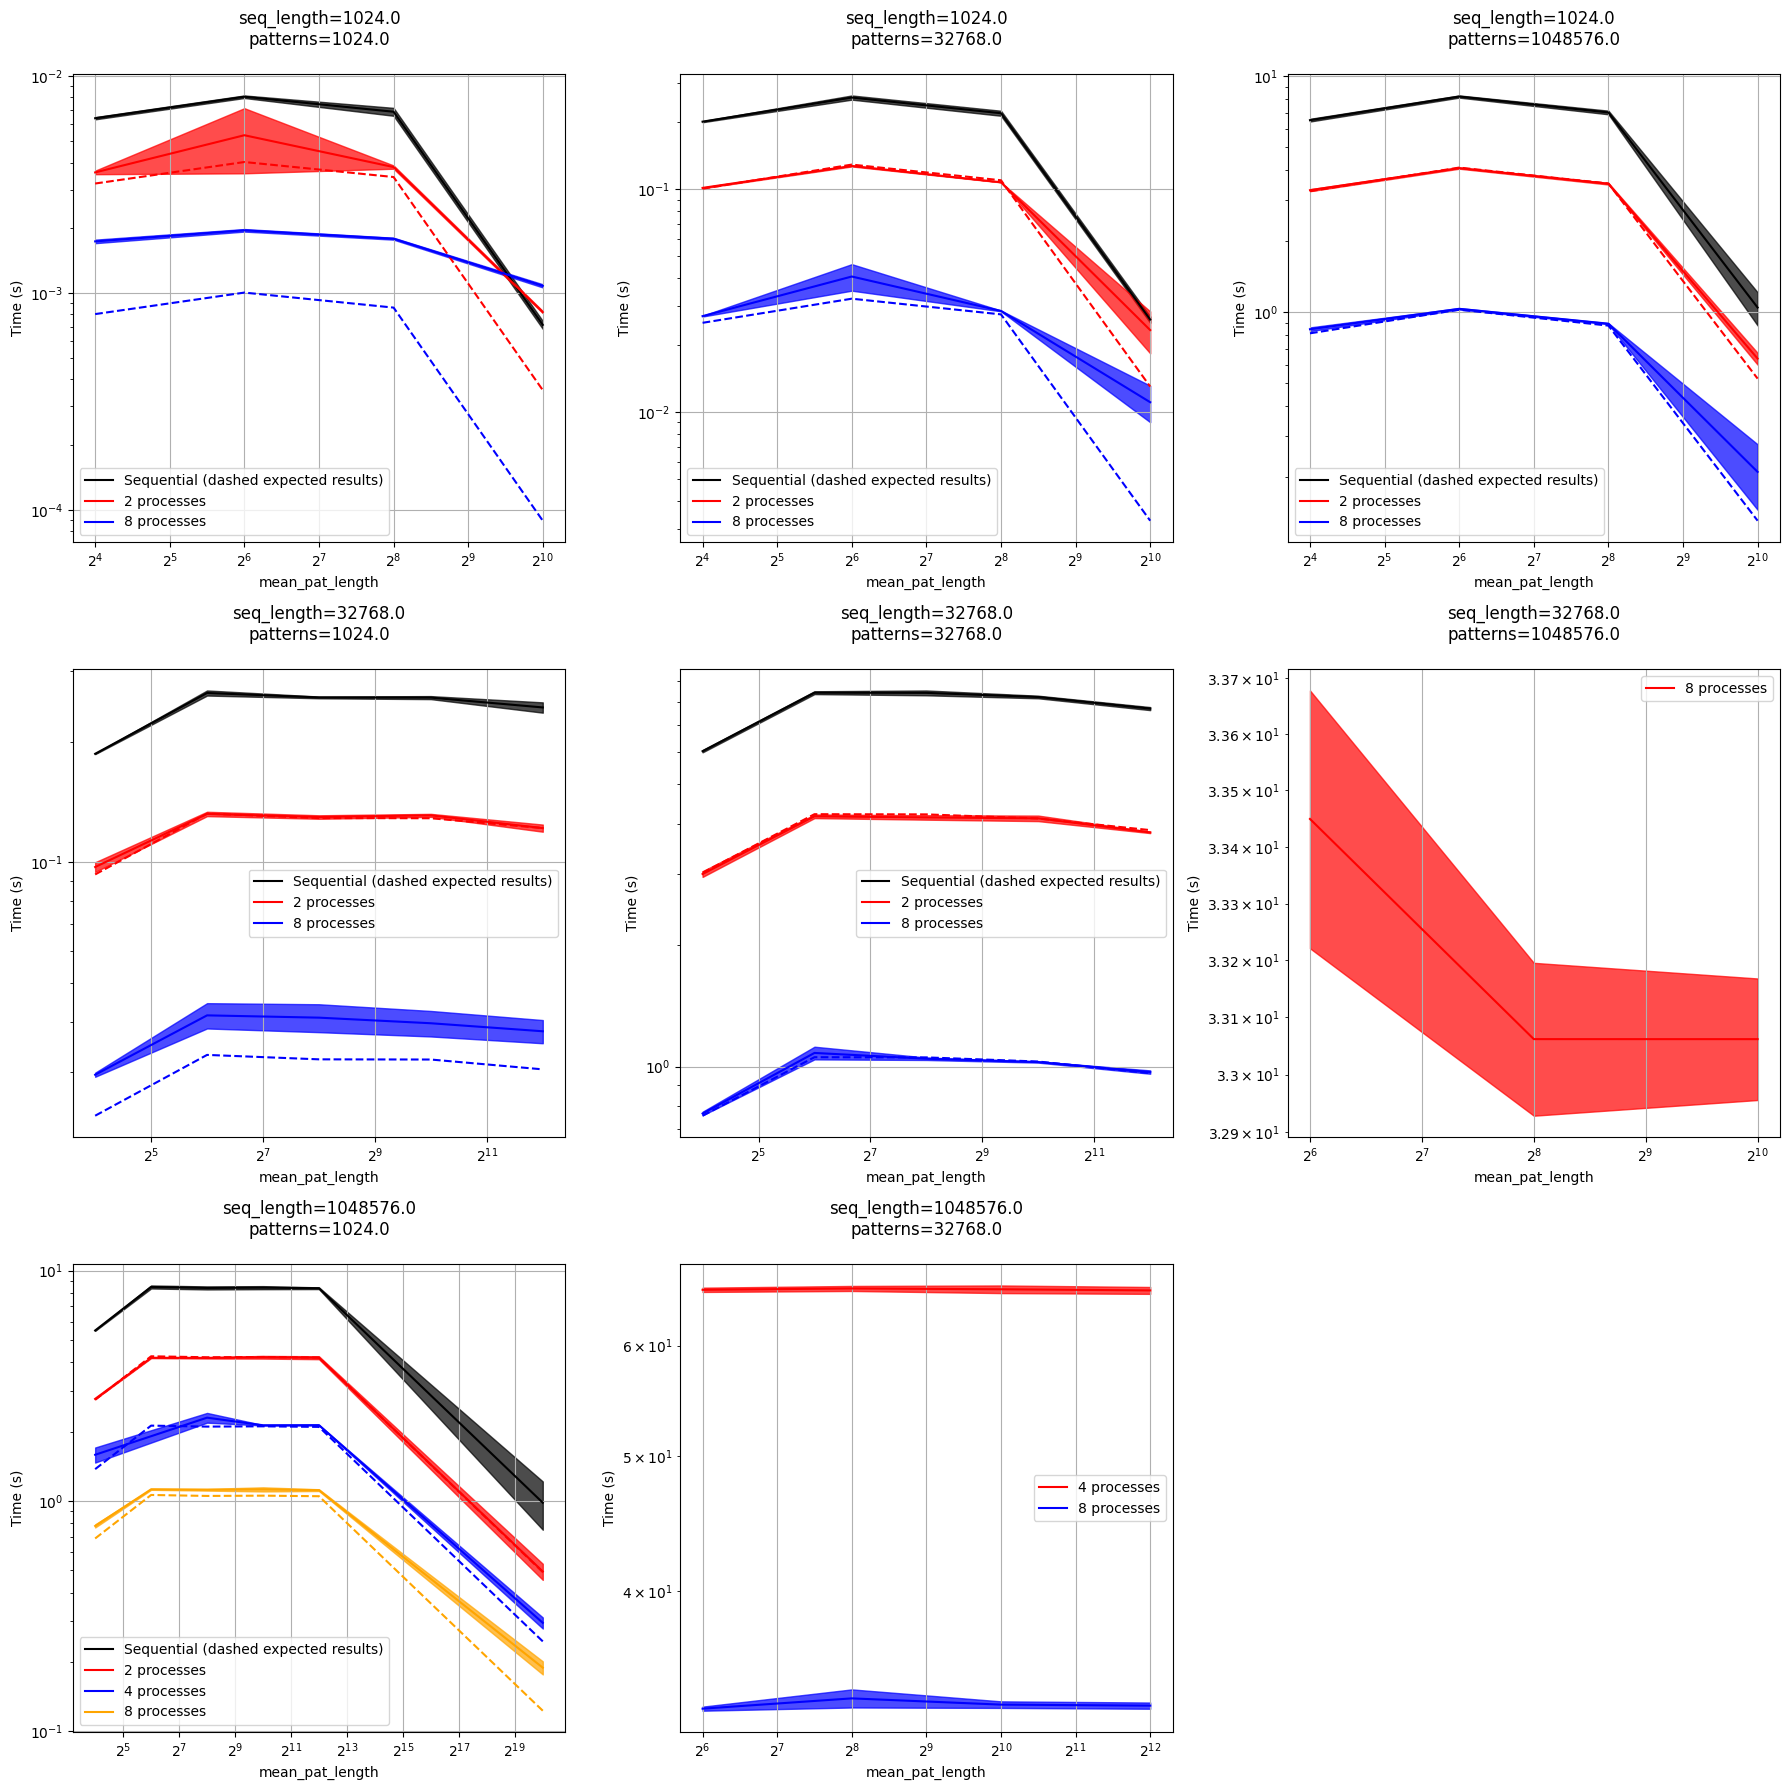

In [53]:
save_plot_variable_sequential_mpi("mpi/broadcast", "mean_pat_length")

## Efficiency

In [87]:
%%capture cap
def save_efficiency(paradigm, variable):
    match paradigm:
        case "pthreads":
            final_efficiency(variable, "pthreads")
        case "mpi/simple":
            final_efficiency(variable, "mpi")
        case "mpi/improved":
            final_efficiency(variable, "mpi_exp")
        case "mpi/broadcast":
            final_efficiency(variable, "mpi_bcast")        
        case _:
            print("Error in paradigm input")
            return

    with open(f"final_folder/results/{paradigm}/efficiency_{variable}.txt", 'w') as f:
        f.write(cap.stdout)

save_efficiency("mpi/broadcast", "seq_length")